<a href="https://colab.research.google.com/github/rahul94jh/MSC-Research/blob/main/YouTube_clickbait_multimodal_USE_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [8]:
import os, sys, math
import numpy as np
import random
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

import tensorflow as tf
import tensorflow_hub as hub
#print("Tensorflow version " + tf.__version__)

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

import keras
from keras import layers, regularizers, optimizers
from keras.layers import Dense, Add, Flatten, Input, Activation, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Lambda, concatenate
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping, ModelCheckpoint
import keras.backend as K

from sklearn.utils import shuffle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

#Import custom script
sys.path.append('/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/scripts')


import tf_dataset_helpers as dh

from tf_dataset_helpers import read_tfrec_data
import model_helpers as mh
import visualization_helpers as vh


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


#Configurations

In [62]:
TARGET_SIZE = [180, 180]
CLASSES = [b'nonclickbaits', b'clickbaits'] 
BATCH_SIZE = 32  # On Colab/GPU, a higher batch size does not help and sometimes does not fit on the GPU (OOM)
EPOCHS=50
VALIDATION_SPLIT = 0.3
TESTING_SPLIT = 0.5
WIDTH = 180
HEIGHT = 180

In [63]:
tfrec_trainVal_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/train_val/'
tfrec_test_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/YouTube_clickbait/tfrec_data/test/'
tfrec_benchmark_files_path = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/dataset/invid_fake_video_v2/tfrec_data/'

In [64]:
#Save weights
checkpoint_filepath = '/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/mm_models/Checkpoints'
clickbait_mm_bert_xception_weights_path = os.path.join(checkpoint_filepath, 'clickbait_mm_USE_xception_weights')

#Save model
MODEL_SAVE_PATH ='/content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/mm_models'
clickbait_mm_bert_xception_path = os.path.join(MODEL_SAVE_PATH, 'clickbait_mm_USE_xception_model')

In [65]:
#instantiate read_data utility
read_data = read_tfrec_data(tfrec_trainVal_files_path, TARGET_SIZE=TARGET_SIZE,  VALIDATION_SPLIT=0.2, TESTING_SPLIT=0.0, MODE=2, SHUFFLE_BUFFER=17000)
read_test_data = read_tfrec_data(tfrec_test_files_path, TARGET_SIZE=TARGET_SIZE, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=2, SHUFFLE_BUFFER=1900) # Used only for testing
read_benchmark_data = read_tfrec_data(tfrec_benchmark_files_path, TARGET_SIZE=TARGET_SIZE, VALIDATION_SPLIT=0.0, TESTING_SPLIT=0.0, MODE=2, SHUFFLE_BUFFER=100) # Used only for benchmarking

num_training_example = 17000
# splitting data files between training, validation and test
filenames, training_filenames, validation_filenames, testing_filenames = read_data.get_tfrec_files()
testing_filenames, _, _,_ = read_test_data.get_tfrec_files()
benchmarking_filenames, _, _,_ = read_benchmark_data.get_tfrec_files()

Pattern matches 30 data files. Splitting dataset into 24 training files , 6 validation files and 0 test files
Pattern matches 2 data files. Splitting dataset into 2 training files , 0 validation files and 0 test files
Pattern matches 4 data files. Splitting dataset into 4 training files , 0 validation files and 0 test files


In [66]:
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, ((image,text), label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(CLASSES[label.numpy()], fontsize=16)
    subplot += 1
    if i==8:
      break
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def title_from_label_and_target(label, correct_label):
  correct = (label == correct_label)
  return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                              CLASSES[correct_label] if not correct else ''), correct

          

def display_one_image(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1
  
def display_9_images_with_predictions(images, predictions, labels):
  subplot=331
  plt.figure(figsize=(13,13))
  for i, image in enumerate(images):
    title, correct = title_from_label_and_target(predictions[i], labels[i])
    subplot = display_one_image(image, title, subplot, not correct)
    if i >= 8:
      break;
              
  #plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        "text": tf.io.FixedLenFeature([], tf.string),
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    text = example['text']
    label  = example['label']
    return image, text, class_num, label

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.

  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  dataset = dataset.map(lambda image, text, class_num, label: ((image,text), class_num))
  return dataset

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.shuffle(num_training_example)
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def create_image_model():
  base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(WIDTH, HEIGHT, 3),
    include_top=False,
  )  
  # Freeze the base_model
  base_model.trainable = False
  # Create new model on top
  inputs = tf.keras.Input(shape=(WIDTH, HEIGHT, 3))

  x = tf.keras.applications.xception.preprocess_input(inputs)
  x = base_model(x, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = tf.keras.layers.Lambda(lambda xz:K.l2_normalize(xz,axis=1))(x)
  model = tf.keras.Model(inputs, outputs)
  return model

def create_text_model():
  text_model = tf.keras.models.Sequential()
  text_model.add(hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4', 
                        input_shape=[], 
                        dtype=tf.string, 
                         trainable=True))
  text_model.add(Dropout(0.15))
  text_model.add(tf.keras.layers.Dense(512, activation='relu'))
  text_model.add(Dropout(0.15))
  text_model.add(Lambda(lambda xz:K.l2_normalize(xz,axis=1)))
  return text_model 

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    #plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Non clickbaits Detected (True Negatives): ', cm[0][0])
  print('Non-Clickbaits Detected as Clickbaits (False Positives): ', cm[0][1])
  print('Clickbaits Detected as Non-clickbaits (False Negatives): ', cm[1][0])
  print('Clickbaits Detected (True Positives): ', cm[1][1])
  print('Total Non-clickbaits: ', np.sum(cm[0]))
  print('Total Clickbaits: ', np.sum(cm[1]))
  
def get_metrics(testy, y_pred):
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(testy, y_pred)
    print('Accuracy: %f' % accuracy)
    # precision tp / (tp + fp)
    precision = precision_score(testy, y_pred)
    print('Precision: %f' % precision)
    # recall: tp / (tp + fn)
    recall = recall_score(testy, y_pred)
    print('Recall: %f' % recall)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(testy, y_pred)
    print('F1 score: %f' % f1)
    # ROC AUC
    auc = roc_auc_score(testy, y_pred)
    print('ROC AUC: %f' % auc)
    # confusion matrix
    matrix = confusion_matrix(testy, y_pred)
    print(matrix)

def predict_on_test(model, ds, N=1):
  test_data = ds.take(N)
  test_image=[]
  y_true=[]
  
  for (images,texts), labels in test_data:
    for i in range(BATCH_SIZE):
      test_image.append(images[i].numpy())
      y_true.append(labels[i].numpy())



  predicted_scores  = model.predict(test_data)
  y_pred = (predicted_scores > 0.5).astype("int32")
  y_pred = y_pred.reshape(-1)
  get_metrics(y_true, y_pred)
  print()
  plot_cm(y_true, predicted_scores)
  return test_image, y_true, y_pred

#Load data

In [91]:
# instantiate the datasets
train_ds = get_batched_dataset(training_filenames, train=True)
val_ds = get_batched_dataset(validation_filenames, train=False)
test_ds = get_batched_dataset(testing_filenames, train=False)
benchmark_ds = get_batched_dataset(benchmarking_filenames, train=False)

In [54]:

for (image, text), class_num in train_ds.take(1):
  for i in range(10):
    print(f"Image shape {image[i].shape}, Text {text[i]}, Class={class_num[i]}, Label={CLASSES[class_num[i]]}")

Image shape (180, 180, 3), Text b'paint explosions the slow mo guys gav and dan repaint the garden the only way they know how with slow motion explosions filmed at fps with a phantom flex follow gav on twitter follow dan on twitter', Class=0, Label=b'nonclickbaits'
Image shape (180, 180, 3), Text b'rob and kristen s babymaking scene was too steamy robert pattinson and kristen stewart got hot and heavy for the filming of breaking dawn but not all of it made the cut listen to them discuss what was too much for the movie and why steamy scenes sometimes aren t all they re cracked up to be', Class=0, Label=b'nonclickbaits'
Image shape (180, 180, 3), Text b'python gui with tkinter introduction facebook github google linkedin reddit support thenewboston twitter', Class=0, Label=b'nonclickbaits'
Image shape (180, 180, 3), Text b'the flash vs audi r get smoked pussy faze adapt merch snapchat adaptsnaps twitter instagram the faze house rain apex teeqo temperrr blaziken gamma labs discount code a

#Build and compile model

##Image model

In [67]:
img_model = create_image_model()
img_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 180, 180, 3)]     0         
_________________________________________________________________
tf.math.truediv_5 (TFOpLambd (None, 180, 180, 3)       0         
_________________________________________________________________
tf.math.subtract_5 (TFOpLamb (None, 180, 180, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 6, 6, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_5 ( (None, 2048)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 512)               104

##Text model

In [68]:
txt_model = create_text_model()
txt_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_5 (KerasLayer)   (None, 512)               256797824 
_________________________________________________________________
dropout_22 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_23 (Dropout)         (None, 512)               0         
_________________________________________________________________
lambda_11 (Lambda)           (None, 512)               0         
Total params: 257,060,480
Trainable params: 257,060,480
Non-trainable params: 0
_________________________________________________________________


##Text-Image combined multi-modal model

In [69]:
merged=concatenate([img_model.output,txt_model.output])
out=Dense(512, activation='relu')(merged)
out =Dense(256, activation='relu')(out)
out =Dense(128, activation='relu')(out)
out =Dense(1, activation='sigmoid')(out)
final_model=Model([img_model.input,txt_model.input],out) 
final_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
tf.math.truediv_5 (TFOpLambda)  (None, 180, 180, 3)  0           input_14[0][0]                   
__________________________________________________________________________________________________
tf.math.subtract_5 (TFOpLambda) (None, 180, 180, 3)  0           tf.math.truediv_5[0][0]          
__________________________________________________________________________________________________
xception (Functional)           (None, 6, 6, 2048)   20861480    tf.math.subtract_5[0][0]         
___________________________________________________________________________________________

In [70]:
LOSS = keras.losses.BinaryCrossentropy()
OPTIMIZER = tf.keras.optimizers.RMSprop(lr=1.6192e-5)
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
 ]

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [71]:
final_model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
    )

#Model Training

In [72]:
#callbacks
es = EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=5,
    mode='max',
    restore_best_weights=True
    )

mcb = tf.keras.callbacks.ModelCheckpoint (
         filepath=clickbait_mm_bert_xception_weights_path,
         save_weights_only=True,
         monitor='val_loss',
         mode='min',
         verbose=1,
         save_best_only=True
        )

In [73]:
history = final_model.fit(
  train_ds,
  steps_per_epoch = 420,
  validation_data=val_ds,
  validation_steps=100,
  epochs=EPOCHS,
  verbose=1,
  callbacks=[es, mcb]
)

Epoch 1/50
420/420 [==============================] - 159s 341ms/step - loss: 0.5643 - tp: 5128.0000 - fp: 1218.0000 - tn: 5676.0000 - fn: 1418.0000 - accuracy: 0.8039 - precision: 0.8081 - recall: 0.7834 - auc: 0.8799 - prc: 0.8902 - val_loss: 0.2721 - val_tp: 1315.0000 - val_fp: 109.0000 - val_tn: 1663.0000 - val_fn: 113.0000 - val_accuracy: 0.9306 - val_precision: 0.9235 - val_recall: 0.9209 - val_auc: 0.9748 - val_prc: 0.9751

Epoch 00001: val_loss improved from inf to 0.27212, saving model to /content/drive/MyDrive/Colab Notebooks/clcikbait_detection/models/mm_models/Checkpoints/clickbait_mm_USE_xception_weights
Epoch 2/50
420/420 [==============================] - 152s 358ms/step - loss: 0.2664 - tp: 5713.0000 - fp: 492.0000 - tn: 6370.0000 - fn: 865.0000 - accuracy: 0.8990 - precision: 0.9207 - recall: 0.8685 - auc: 0.9641 - prc: 0.9665 - val_loss: 0.1373 - val_tp: 1330.0000 - val_fp: 78.0000 - val_tn: 1694.0000 - val_fn: 98.0000 - val_accuracy: 0.9450 - val_precision: 0.9446 - 

In [74]:
#final_model.save('/content/drive/MyDrive/Colab Notebooks/Clickbait detection/model_path/simple_mm_model')

#Plot training history

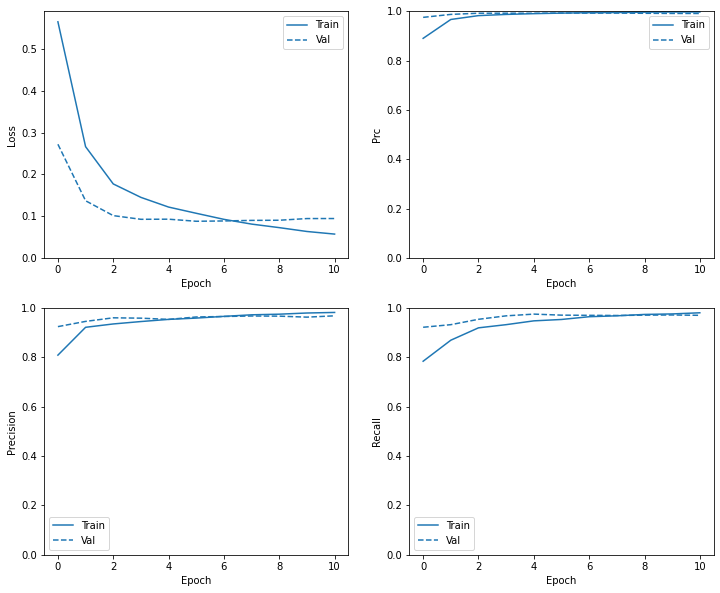

In [82]:
plot_metrics(history)

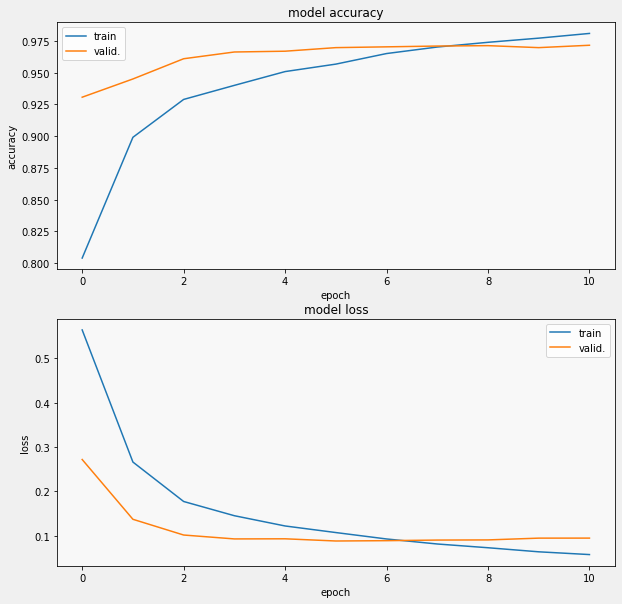

In [83]:
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

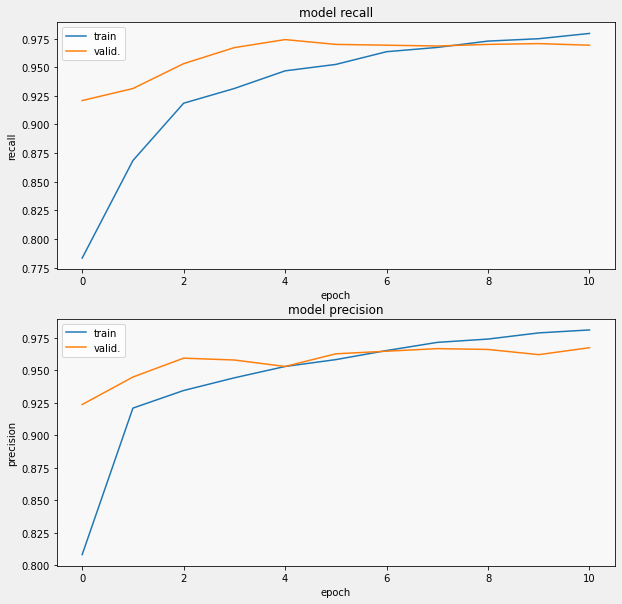

In [84]:
display_training_curves(history.history['recall'], history.history['val_recall'], 'recall', 211)
display_training_curves(history.history['precision'], history.history['val_precision'], 'precision', 212)

#Predictions

In [85]:
#saved_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Clickbait detection/model_path/simple_mm_model')

In [86]:
results = final_model.evaluate(test_ds)

for name, value in zip(final_model.metrics_names, results):
  print(name, ': ', value)
print()
  

61/61 [==============================] - 13s 216ms/step - loss: 0.0859 - tp: 890.0000 - fp: 29.0000 - tn: 1007.0000 - fn: 22.0000 - accuracy: 0.9738 - precision: 0.9684 - recall: 0.9759 - auc: 0.9945 - prc: 0.9935
loss :  0.0858941376209259
tp :  890.0
fp :  29.0
tn :  1007.0
fn :  22.0
accuracy :  0.9738193154335022
precision :  0.9684439897537231
recall :  0.9758771657943726
auc :  0.9945322871208191
prc :  0.9934827089309692



Accuracy: 0.966667
Precision: 0.961702
Recall: 0.969957
F1 score: 0.965812
ROC AUC: 0.966760
[[238   9]
 [  7 226]]

Non clickbaits Detected (True Negatives):  238
Non-Clickbaits Detected as Clickbaits (False Positives):  9
Clickbaits Detected as Non-clickbaits (False Negatives):  7
Clickbaits Detected (True Positives):  226
Total Non-clickbaits:  247
Total Clickbaits:  233


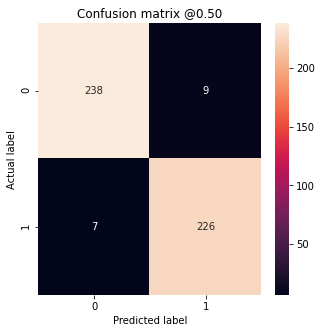

In [87]:
test_image, y_true, y_pred = predict_on_test(final_model,test_ds,N=15)

#Benchmarking

In [92]:
results = final_model.evaluate(benchmark_ds)

for name, value in zip(final_model.metrics_names, results):
  print(name, ': ', value)
print()

6/6 [==============================] - 2s 397ms/step - loss: 0.5523 - tp: 68.0000 - fp: 8.0000 - tn: 61.0000 - fn: 26.0000 - accuracy: 0.7914 - precision: 0.8947 - recall: 0.7234 - auc: 0.8886 - prc: 0.9230
loss :  0.5523228049278259
tp :  68.0
fp :  8.0
tn :  61.0
fn :  26.0
accuracy :  0.7914110422134399
precision :  0.8947368264198303
recall :  0.7234042286872864
auc :  0.8886063098907471
prc :  0.9229538440704346



Accuracy: 0.787500
Precision: 0.894737
Recall: 0.723404
F1 score: 0.800000
ROC AUC: 0.801096
[[58  8]
 [26 68]]

Non clickbaits Detected (True Negatives):  58
Non-Clickbaits Detected as Clickbaits (False Positives):  8
Clickbaits Detected as Non-clickbaits (False Negatives):  26
Clickbaits Detected (True Positives):  68
Total Non-clickbaits:  66
Total Clickbaits:  94


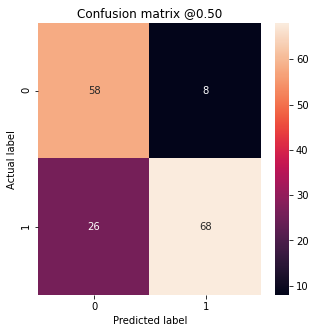

In [93]:
test_image, y_true, y_pred = predict_on_test(final_model,benchmark_ds,N=5)
